<a href="https://colab.research.google.com/github/luoChengwen/Tensorflow_test/blob/master/Transfer_Learning_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-08-08 02:53:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   225MB/s    in 0.4s    

2019-08-08 02:53:42 (225 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



W0808 02:53:43.412874 140705241556864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


last layer output shape:  (None, 7, 7, 768)


In [0]:
import tensorflow as tf
model2 = tf.keras.models.Sequential()
model2.add(pre_trained_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(1024, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])




In [9]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2019-08-08 03:14:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c10::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   267MB/s    in 0.2s    

2019-08-08 03:14:05 (267 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 24s - loss: 0.5044 - acc: 0.7500 - val_loss: 0.1553 - val_acc: 0.9480
Epoch 2/20
100/100 - 17s - loss: 0.3732 - acc: 0.8340 - val_loss: 0.1973 - val_acc: 0.9520
Epoch 3/20
100/100 - 18s - loss: 0.3428 - acc: 0.8515 - val_loss: 0.2500 - val_acc: 0.9400
Epoch 4/20
100/100 - 17s - loss: 0.3223 - acc: 0.8570 - val_loss: 0.6249 - val_acc: 0.9060
Epoch 5/20
100/100 - 17s - loss: 0.3232 - acc: 0.8645 - val_loss: 0.2734 - val_acc: 0.9480
Epoch 6/20
100/100 - 17s - loss: 0.3197 - acc: 0.8700 - val_loss: 0.3716 - val_acc: 0.9400
Epoch 7/20
100/100 - 17s - loss: 0.2915 - acc: 0.8810 - val_loss: 0.3720 - val_acc: 0.9470
Epoch 8/20
100/100 - 17s - loss: 0.3085 - acc: 0.8700 - val_loss: 0.3150 - val_acc: 0.9550
Epoch 9/20
100/100 - 17s - loss: 0.2979 - acc: 0.8800 - val_loss: 0.4888 - val_acc: 0.9390
Epoch 10/20
100/100 - 17s - loss: 0.2817 - acc: 0.8820 - val_loss: 0.3245 - val_acc: 0.9550
Epoch 11/20
100/100 - 17s - loss: 0.2587 - acc: 0.8950 - val_loss: 0.5575 - val_acc: 0.93

In [11]:
history2 = model2.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 22s - loss: 0.8201 - acc: 0.6460 - val_loss: 0.2718 - val_acc: 0.9300
Epoch 2/20
100/100 - 18s - loss: 0.5445 - acc: 0.7525 - val_loss: 0.2307 - val_acc: 0.9420
Epoch 3/20
100/100 - 17s - loss: 0.4782 - acc: 0.7820 - val_loss: 0.2633 - val_acc: 0.9480
Epoch 4/20
100/100 - 18s - loss: 0.4890 - acc: 0.7855 - val_loss: 0.5074 - val_acc: 0.9260
Epoch 5/20
100/100 - 18s - loss: 0.4831 - acc: 0.7850 - val_loss: 1.2119 - val_acc: 0.8460
Epoch 6/20
100/100 - 18s - loss: 0.4703 - acc: 0.7880 - val_loss: 0.3198 - val_acc: 0.9390
Epoch 7/20
100/100 - 17s - loss: 0.4895 - acc: 0.7805 - val_loss: 0.2660 - val_acc: 0.9520
Epoch 8/20
100/100 - 18s - loss: 0.4532 - acc: 0.7980 - val_loss: 0.2981 - val_acc: 0.9510
Epoch 9/20
100/100 - 18s - loss: 0.4546 - acc: 0.7940 - val_loss: 0.4706 - val_acc: 0.9370
Epoch 10/20
100/100 - 18s - loss: 0.4341 - acc: 0.8105 - val_loss: 0.3481 - val_acc: 0.9480
Epoch 11/20
100/100 - 18s - loss: 0.4190 - acc: 0.8230 - val_loss: 0.7608 - val_acc: 0.91

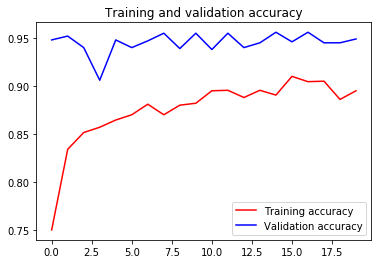

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

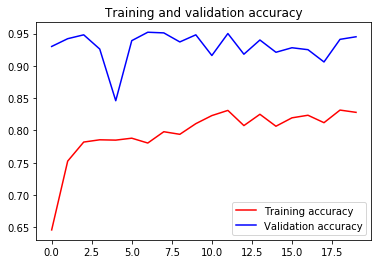

<Figure size 432x288 with 0 Axes>

In [13]:

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()